In [1]:
import time
import gc
import os
import sys
import torch
import subprocess
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import transforms
from torchvision.models import vit_b_16
from torch.utils.data import DataLoader

In [2]:
# Custom imports assuming they are in the parent directory
current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)
sys.path.append(parent_dir)
from data_utils import ContDataset, Transform
from models import Decoder, MaskedAutoEncoder
from losses import contrastive_loss, dice_loss
from metrics import pixel_wise_accuracy, evaluate_model_performance
from data_augmentation import DataAugmentation
from utils import test_visualization

In [3]:
# Configuration for datasets
batch_size = 64
dataset_config = {
    'image_size': (224, 224),
    'data_path': '../datasets/data',
    'aug_data_path': '../datasets/aug_data'
}

pre_train = {
    'num_samples': 10000, # Size of the pre-trained dataset
    'epochs': 10,  # Total epochs for pre-training
    'learning_rate': 1e-3 # Learning rate in the pre-training phase
}

# Split configurations for fine-tuning
fine_tune_dataset_split = {
    'use_data_ratio': 1.0, # Fine-tuning the use ratio of the dataset
    'train_ratio': 0.8,  # Fine-tuning the scale of the training dataset
    'test_ratio': 0.2, #Fine-tuning the scale of the test dataset
}

# Training configuration for fine-tuning
fine_tune_training_config = {
    'batch_size': 64, 
    'shuffle_train': True,  
    'shuffle_test': False,
    'training_epochs' : 20, # Fine-tuning phase training epochs
    'learning_rate': 1e-4 # Learning rate in the pre-training phase
}

# Pre-Train

In [4]:
# Unzip dataset if not already present
if not os.path.exists(dataset_config['data_path']):
    subprocess.run(f'unzip ../datasets/data.zip -d {"../datasets"}', 
                   shell=True, stdout=subprocess.DEVNULL, 
                   stderr=subprocess.DEVNULL)
else:
    print("The data folder already exists, no need to unzip it again")

# Initialize data augmentation module
augmentor = DataAugmentation(dataset_config['data_path'], 
                             dataset_config['aug_data_path'], 
                             pre_train['num_samples'])
augmentor.augment_images()

# List files and count them in each directory using subprocess
data_files_count = subprocess.check_output(f'ls -1 {dataset_config["data_path"]} | wc -l', shell=True).strip().decode()
aug_data_files_count = subprocess.check_output(f'ls -1 {dataset_config["aug_data_path"]} | wc -l', shell=True).strip().decode()
print(f"Number of files in data directory: {data_files_count}")
print(f"Number of files in aug_data directory - Pre-training dataset: {aug_data_files_count}")

# Define a transform to convert the images to PyTorch tensors and any other desired transformations
transform = transforms.Compose([
    transforms.Resize(dataset_config['image_size']),  # Resize the image to 224x224 pixels.
    transforms.ToTensor(),  # Convert the image to a PyTorch tensor.
])

# Load dataset and create dataloader
dataset = ContDataset(folder_path=dataset_config['aug_data_path'], 
                      folder_path1=dataset_config['data_path'], 
                      transform=transform)
dataloader = DataLoader(dataset, batch_size=batch_size , shuffle=False)

The data folder already exists, no need to unzip it again


100%|██████████| 10000/10000 [02:05<00:00, 79.80it/s]


Number of files in data directory: 48062
Number of files in aug_data directory - Pre-training dataset: 20000


In [5]:
# Setup model and training devices
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
encoder = vit_b_16(pretrained=False).to(device)
decoder = Decoder(1000, 512, 3 * 224 * 224).to(device)
pre_model = MaskedAutoEncoder(encoder, decoder).to(device)
optimizer = optim.Adam(pre_model.parameters(), lr=pre_train['learning_rate'])
mask = torch.rand(size=(1, 3, 224, 224)) > 0.5
mask = mask.to(device)
scaler = torch.cuda.amp.GradScaler()

/root/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/root/miniconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [6]:
# Start the pre-training phase
print("Starting the pre-training phase...")

for epoch in range(pre_train['epochs']):
    start_time = time.time()
    pre_model.train()
    epoch_losses = []  # Collect losses for each batch to calculate epoch average

    for x, z1, z2 in dataloader:
        inputs, x1, x2 = x.to("cuda"), z1.to("cuda"), z2.to("cuda")
        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            try:
                p1, p2 = pre_model(x1, mask).reshape(64,3,224,224), pre_model(x2, mask).reshape(64,3,224,224)
                loss = contrastive_loss(inputs, p1, p2)
                epoch_losses.append(loss.item())

            except Exception as e:
                continue  # Skip the backward pass and optimizer step if an error occurred

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

    # Calculate and print the average loss for the epoch
    epoch_avg_loss = sum(epoch_losses) / len(epoch_losses) if epoch_losses else float('inf')
    end_time = time.time()
    epoch_duration = end_time - start_time
    print(f'Epoch {epoch+1}, Avg. Loss: {epoch_avg_loss:.3f}, Duration: {epoch_duration:.2f} seconds')

print("Pre-training phase completed.")

Starting the pre-training phase...
Epoch 1, Avg. Loss: 16.977, Duration: 277.19 seconds
Epoch 2, Avg. Loss: 15.380, Duration: 277.09 seconds
Epoch 3, Avg. Loss: 15.308, Duration: 275.27 seconds
Epoch 4, Avg. Loss: 15.272, Duration: 274.75 seconds
Epoch 5, Avg. Loss: 15.245, Duration: 275.59 seconds
Epoch 6, Avg. Loss: 15.253, Duration: 274.74 seconds
Epoch 7, Avg. Loss: 15.205, Duration: 275.12 seconds
Epoch 8, Avg. Loss: 15.216, Duration: 275.92 seconds
Epoch 9, Avg. Loss: 15.231, Duration: 275.60 seconds
Epoch 10, Avg. Loss: 15.193, Duration: 275.24 seconds
Pre-training phase completed.


# Fine-tuning of pre-trained models

In [7]:
# When initializing your OxfordIIITPet dataset, you can use:
transform = Transform(image_size = dataset_config['image_size'])
full_dataset = torchvision.datasets.OxfordIIITPet(root='../datasets',
                        target_types='segmentation',
                        transforms=transform,
                        download=True)


# Define the size of training and testing datasets
total_size = len(full_dataset)
used_data_size = int(total_size * fine_tune_dataset_split['use_data_ratio'])
train_size = int(used_data_size * fine_tune_dataset_split['train_ratio'])
test_size = used_data_size - train_size

# Split the dataset
indices = torch.randperm(total_size).tolist()
used_indices = indices[:used_data_size]
train_indices = used_indices[:train_size]
test_indices = used_indices[train_size:]

train_dataset = torch.utils.data.Subset(full_dataset, train_indices)
test_dataset = torch.utils.data.Subset(full_dataset, test_indices)


print(f"Fine-tuning Original dataset size: {total_size}")
print(f"Fine-tuning Used dataset size: {used_data_size} ({fine_tune_dataset_split['use_data_ratio']*100}%)")
print(f"Fine-tuning Training dataset size: {len(train_dataset)}")
print(f"Fine-tuning Testing dataset size: {len(test_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=fine_tune_training_config['batch_size'], shuffle=fine_tune_training_config['shuffle_train'], drop_last=True)
test_loader = DataLoader(test_dataset, batch_size=4, shuffle=fine_tune_training_config['shuffle_test'], drop_last=True)

Fine-tuning Original dataset size: 3680
Fine-tuning Used dataset size: 3680 (100.0%)
Fine-tuning Training dataset size: 2944
Fine-tuning Testing dataset size: 736


In [8]:
evaluate_model_performance(pre_model, test_loader, device, mask, "the pre-trained model")

Accuracy of the pre-trained model on the fine-tuning test dataset: 0.32
IoU score of the pre-trained model on the fine-tuning test dataset: 0.18


In [9]:
# Initialize mask and model for fine-tuning
mask = torch.ones(size=(1, 3, 224, 224)).to(device)
fine_model_with_pre = pre_model.to(device)
optimizer = optim.Adam(fine_model_with_pre.parameters(), lr=fine_tune_training_config['learning_rate'])

# Start the fine-tuning process
print("Starting the fine-tuning process with the pre-trained model...")

for epoch in range(fine_tune_training_config['training_epochs']):
    start_time = time.time()
    fine_model_with_pre.train()  # Ensure the model is in training mode
    for x, y in train_loader:
        inputs, targets = x.to(device), y.to(device)
        optimizer.zero_grad()

        # Generate predictions using the fine-tuned model
        preds = fine_model_with_pre(inputs, mask)
        if preds.size(0) == inputs.size(0):
            batch_size = preds.shape[0]
            preds = preds.reshape(batch_size, 3, 224, 224)
    
            # Compute the loss and accuracy
            loss = dice_loss(preds, targets)
            accuracy = pixel_wise_accuracy(preds, targets)
    
            # Backpropagation
            loss.backward()
            optimizer.step()
        
    end_time = time.time()
    epoch_duration = end_time - start_time

    # Print epoch results
    print(f'Epoch {epoch+1}, Loss: {loss.item():.3f}, Accuracy: {accuracy:.3f}, Duration: {epoch_duration:.2f} seconds')

print("Fine-tuning completed.")

Starting the fine-tuning process with the pre-trained model...
Epoch 1, Loss: 0.681, Accuracy: 0.390, Duration: 18.88 seconds
Epoch 2, Loss: 0.492, Accuracy: 0.636, Duration: 18.56 seconds
Epoch 3, Loss: 0.490, Accuracy: 0.636, Duration: 18.48 seconds
Epoch 4, Loss: 0.486, Accuracy: 0.646, Duration: 18.53 seconds
Epoch 5, Loss: 0.500, Accuracy: 0.639, Duration: 18.50 seconds
Epoch 6, Loss: 0.488, Accuracy: 0.631, Duration: 18.68 seconds
Epoch 7, Loss: 0.488, Accuracy: 0.638, Duration: 18.55 seconds
Epoch 8, Loss: 0.473, Accuracy: 0.658, Duration: 18.72 seconds
Epoch 9, Loss: 0.493, Accuracy: 0.637, Duration: 18.53 seconds
Epoch 10, Loss: 0.493, Accuracy: 0.633, Duration: 18.49 seconds
Epoch 11, Loss: 0.481, Accuracy: 0.651, Duration: 18.62 seconds
Epoch 12, Loss: 0.485, Accuracy: 0.644, Duration: 18.54 seconds
Epoch 13, Loss: 0.479, Accuracy: 0.646, Duration: 18.61 seconds
Epoch 14, Loss: 0.484, Accuracy: 0.643, Duration: 18.57 seconds
Epoch 15, Loss: 0.481, Accuracy: 0.643, Duration: 

Accuracy of the fine-tuned model on the fine-tuning test dataset: 0.64
IoU score of the fine-tuned model on the fine-tuning test dataset: 0.39


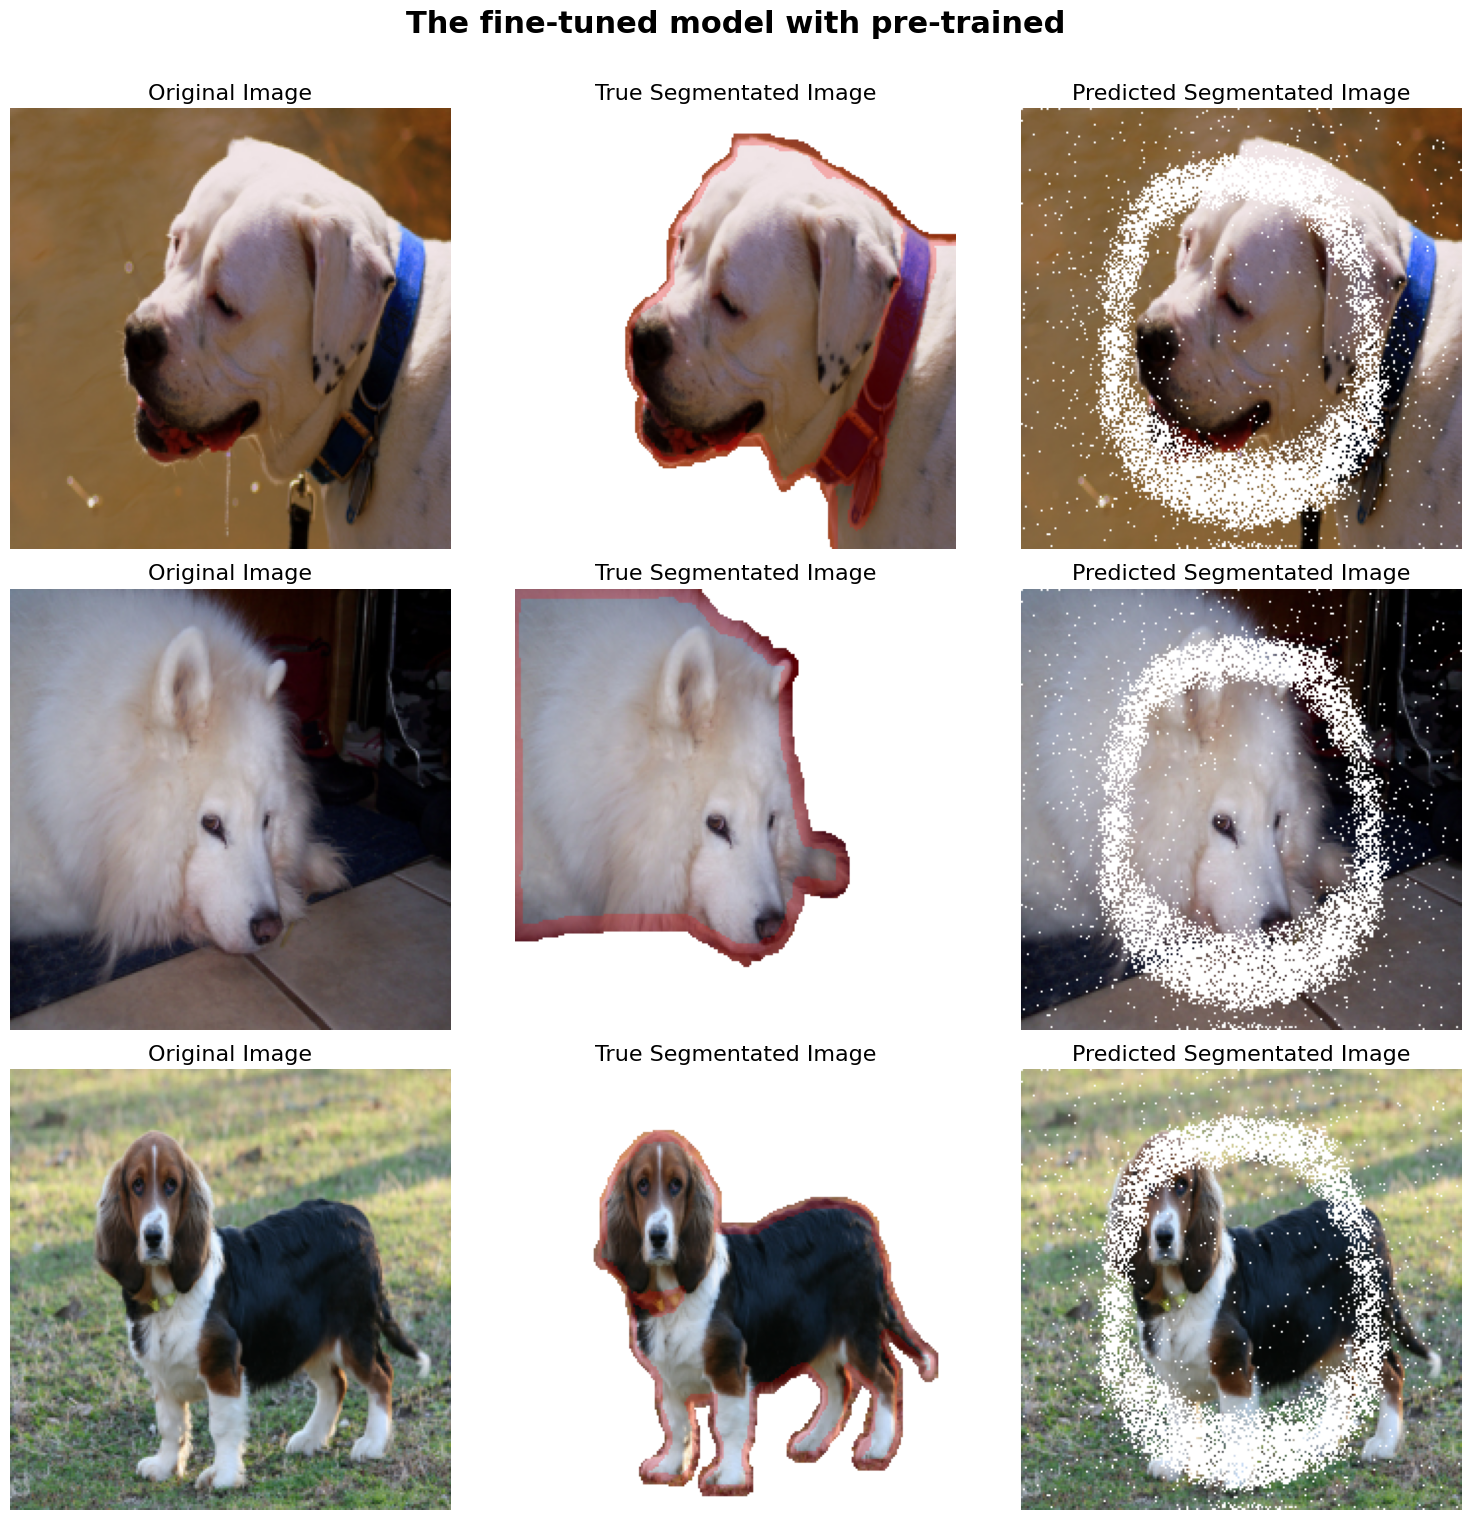

25247

In [10]:
evaluate_model_performance(fine_model_with_pre, test_loader, device, mask, "the fine-tuned model")

test_visualization(fine_model_with_pre, test_loader, mask, device, f"The fine-tuned model with pre-trained", "../images")

# Freeing up graphics card memory
fine_model_with_pre.to('cpu')
torch.cuda.empty_cache()  
gc.collect()

# Fine-tuning from scratch models (baseline models)

In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Initialize the baseline model components
encoder = vit_b_16(pretrained=False).to(device)
decoder = Decoder(1000, 512, 3*224*224).to(device)
fine_model_without_pre = MaskedAutoEncoder(encoder, decoder).to(device)
mask = torch.ones(size=(1,3,224,224))
mask = mask.to(device)
# Set up the optimizer for the baseline model
optimizer = optim.Adam(fine_model_without_pre.parameters(), lr=fine_tune_training_config['learning_rate'])

# Start training the baseline model
print("Starting training of the baseline model without pre-trained weights...")

for epoch in range(fine_tune_training_config['training_epochs']):
    start_time = time.time()
    fine_model_without_pre.train()  # Ensure the model is in training mode
    for x, y in train_loader:
        inputs, targets = x.to("cuda"), y.to("cuda")
        optimizer.zero_grad()

        # Forward pass
        preds = fine_model_without_pre(inputs, mask)
        if preds.size(0) == inputs.size(0):
            batch_size = preds.shape[0]
            preds = preds.reshape(batch_size, 3, 224, 224)
    
            # Compute loss and accuracy
            loss = dice_loss(preds, targets)
            accuracy = pixel_wise_accuracy(preds, targets)
    
            # Backpropagation
            loss.backward()
            optimizer.step()

    end_time = time.time()
    epoch_duration = end_time - start_time

    # Print training progress
    print(f'Epoch {epoch+1}, Loss: {loss.item():.3f}, Accuracy: {accuracy:.3f}, Duration: {epoch_duration:.2f} seconds')

print("Baseline model without pre-trained weights training completed.")

Starting training of the baseline model without pre-trained weights...
Epoch 1, Loss: 0.487, Accuracy: 0.648, Duration: 19.22 seconds
Epoch 2, Loss: 0.469, Accuracy: 0.654, Duration: 18.85 seconds
Epoch 3, Loss: 0.490, Accuracy: 0.650, Duration: 18.75 seconds
Epoch 4, Loss: 0.502, Accuracy: 0.640, Duration: 18.65 seconds
Epoch 5, Loss: 0.492, Accuracy: 0.643, Duration: 18.69 seconds
Epoch 6, Loss: 0.505, Accuracy: 0.630, Duration: 18.89 seconds
Epoch 7, Loss: 0.486, Accuracy: 0.639, Duration: 18.71 seconds
Epoch 8, Loss: 0.505, Accuracy: 0.632, Duration: 18.68 seconds
Epoch 9, Loss: 0.472, Accuracy: 0.652, Duration: 18.67 seconds
Epoch 10, Loss: 0.483, Accuracy: 0.645, Duration: 18.68 seconds
Epoch 11, Loss: 0.487, Accuracy: 0.643, Duration: 18.84 seconds
Epoch 12, Loss: 0.489, Accuracy: 0.643, Duration: 18.71 seconds
Epoch 13, Loss: 0.477, Accuracy: 0.654, Duration: 18.77 seconds
Epoch 14, Loss: 0.484, Accuracy: 0.648, Duration: 18.75 seconds
Epoch 15, Loss: 0.493, Accuracy: 0.639, Du

In [12]:
evaluate_model_performance(fine_model_without_pre, test_loader, device, mask, "the baseline model without pre-trained")

Accuracy of the baseline model without pre-trained on the fine-tuning test dataset: 0.65
IoU score of the baseline model without pre-trained on the fine-tuning test dataset: 0.39


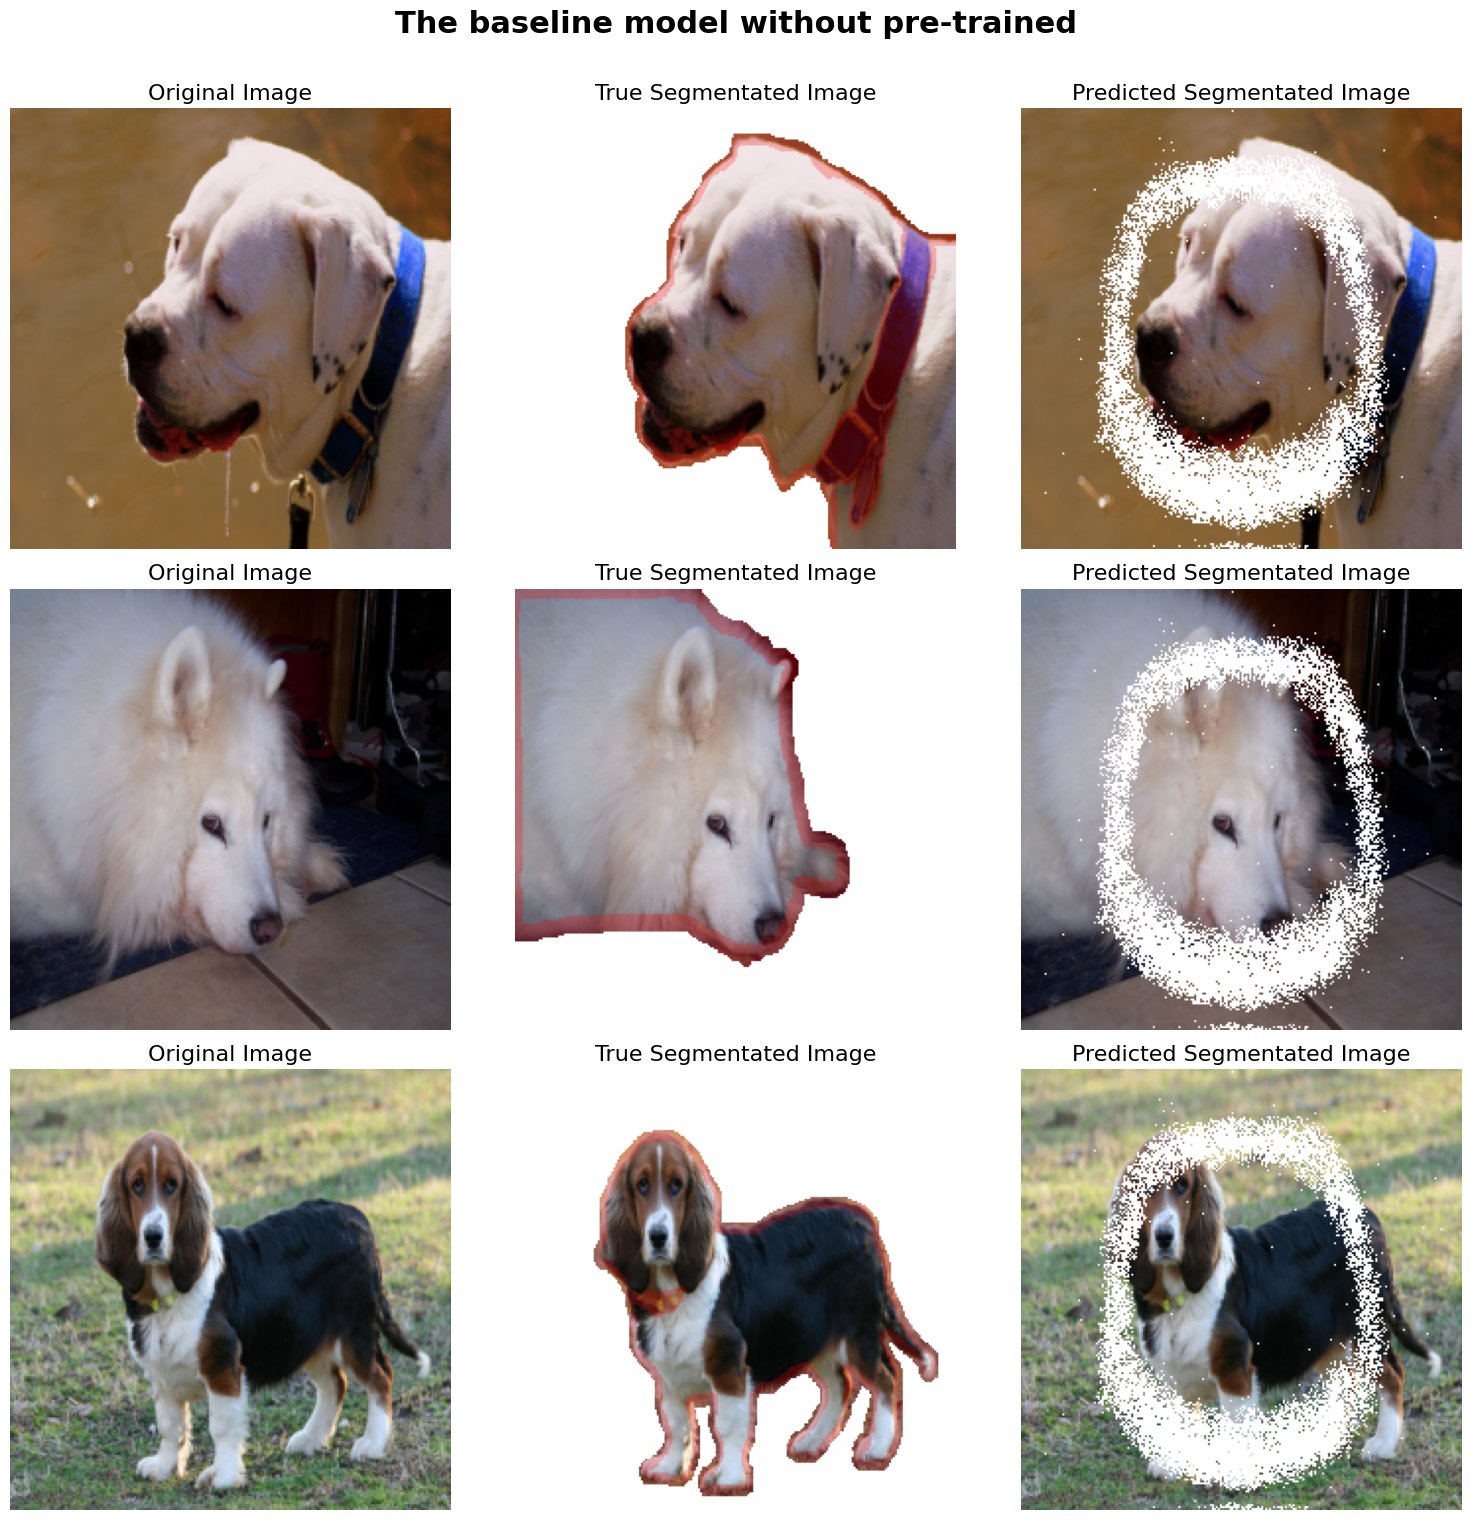

In [13]:
test_visualization(fine_model_without_pre, test_loader, mask, device, f"The baseline model without pre-trained", "../images")